# TabNet Notebook
Based on: https://github.com/dreamquark-ai/tabnet.git


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# If you need to adjust the path below, please adjust the path in the 'Data_Preperation_...' file accordingly
%cd /content/drive/MyDrive/Energy_Prediction/models/self_supervised/tabnet

/content/drive/MyDrive/self_supervised/tabnet


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
import numpy as np
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
np.random.seed(0)
torch.manual_seed(0)

from matplotlib import pyplot as plt
from Data_Preperation_TabNet import X_pretrain, X_train, y_train, X_test, y_test, X_valid, y_valid

%matplotlib inline

# Without Pretraining

In [ ]:
# Convert training and validation data to numpy arrays
X_train_np = X_train
y_train_np = y_train
X_test_np = X_test
y_test_np = y_test
X_valid_np = X_valid
y_valid_np = y_valid

print(X_train_np.shape, y_train_np.shape, X_test_np.shape, y_test_np.shape, X_valid_np.shape, y_valid_np.shape)

clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=0.02 ),
                       scheduler_params={"step_size":50, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax')

(1620, 51) (1620,) (87, 51) (87,) (88, 51) (88,)


In [ ]:
clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_valid_np, y_valid_np)],
    eval_name=['train', 'valid'],
    max_epochs=1000,
    patience=50,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False,
)

epoch 0  | loss: 2.48948 | train_accuracy: 0.11975 | valid_accuracy: 0.17045 |  0:00:02s
epoch 1  | loss: 2.28682 | train_accuracy: 0.15247 | valid_accuracy: 0.18182 |  0:00:02s
epoch 2  | loss: 2.19909 | train_accuracy: 0.19259 | valid_accuracy: 0.22727 |  0:00:02s
epoch 3  | loss: 2.08268 | train_accuracy: 0.22531 | valid_accuracy: 0.25    |  0:00:03s
epoch 4  | loss: 2.00116 | train_accuracy: 0.23951 | valid_accuracy: 0.29545 |  0:00:03s
epoch 5  | loss: 1.93877 | train_accuracy: 0.2642  | valid_accuracy: 0.30682 |  0:00:03s
epoch 6  | loss: 1.87907 | train_accuracy: 0.29321 | valid_accuracy: 0.34091 |  0:00:04s
epoch 7  | loss: 1.7799  | train_accuracy: 0.30802 | valid_accuracy: 0.35227 |  0:00:04s
epoch 8  | loss: 1.70778 | train_accuracy: 0.3463  | valid_accuracy: 0.36364 |  0:00:04s
epoch 9  | loss: 1.59044 | train_accuracy: 0.37654 | valid_accuracy: 0.39773 |  0:00:05s
epoch 10 | loss: 1.46376 | train_accuracy: 0.4284  | valid_accuracy: 0.5     |  0:00:05s
epoch 11 | loss: 1.39

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Validation Accuracy: 0.8735632183908046
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00        22
         3.0       1.00      0.83      0.91         6
         4.0       0.71      1.00      0.83        10
         5.0       1.00      0.57      0.73         7
         6.0       1.00      0.85      0.92        13
         7.0       0.78      0.88      0.82         8
         8.0       0.67      0.86      0.75         7
         9.0       0.83      0.71      0.77         7
        10.0       0.86      0.86      0.86         7

    accuracy                           0.87        87
   macro avg       0.87      0.84      0.84        87
weighted avg       0.90      0.87      0.87        87



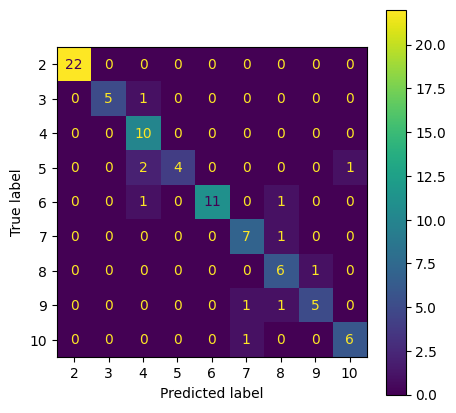

In [ ]:
y_pred = clf.predict(X_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
print(f"Validation Accuracy: {accuracy}")

print(classification_report(y_test_np, y_pred))
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2, 11))

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

In [ ]:
class_accuracies = {i: 0 for i in range(2, 11)}
for j in range(2, 11):
    idx = j - 2
    class_accuracy = cm[idx, idx] / np.sum(cm[idx, :])
    class_accuracies[j] = class_accuracy


# With Pretraining

In [ ]:
pretrainer = TabNetPretrainer(optimizer_fn=torch.optim.Adam,
                              optimizer_params=dict(lr=2e-2),
                              mask_type='entmax',
                              n_shared=3, # TODO: Change to 2 if using the 10/90 split
                              n_independent=3) # TODO: Change to 2 if using the 10/90 split

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
pretrainer.fit(
    X_train=X_pretrain,
    eval_set=[X_valid_np],
    max_epochs=1000,
    patience=10,
    batch_size=512,
    virtual_batch_size=256,
    num_workers=0,
    drop_last=False,
)

epoch 0  | loss: 10.67642| val_0_unsup_loss_numpy: 2.5457398891448975|  0:00:00s
epoch 1  | loss: 2.91798 | val_0_unsup_loss_numpy: 1.3233699798583984|  0:00:01s
epoch 2  | loss: 1.58168 | val_0_unsup_loss_numpy: 1.1476099491119385|  0:00:01s
epoch 3  | loss: 1.18938 | val_0_unsup_loss_numpy: 1.2441600561141968|  0:00:02s
epoch 4  | loss: 1.10993 | val_0_unsup_loss_numpy: 1.1043399572372437|  0:00:02s
epoch 5  | loss: 1.03025 | val_0_unsup_loss_numpy: 0.9942100048065186|  0:00:03s
epoch 6  | loss: 0.99084 | val_0_unsup_loss_numpy: 0.9732300043106079|  0:00:03s
epoch 7  | loss: 0.97748 | val_0_unsup_loss_numpy: 0.942520022392273|  0:00:04s
epoch 8  | loss: 0.96344 | val_0_unsup_loss_numpy: 0.9398999810218811|  0:00:04s
epoch 9  | loss: 0.96357 | val_0_unsup_loss_numpy: 0.9346799850463867|  0:00:04s
epoch 10 | loss: 0.94609 | val_0_unsup_loss_numpy: 0.9262599945068359|  0:00:05s
epoch 11 | loss: 0.94609 | val_0_unsup_loss_numpy: 0.9172999858856201|  0:00:05s
epoch 12 | loss: 0.94178 | va

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
clf2 = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax')

In [ ]:
clf2.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_valid_np, y_valid_np)],
    eval_name=['train', 'valid'],
    max_epochs=1000,
    patience=50,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=pretrainer
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: n_independent changed from 2 to 3
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: n_shared changed from 2 to 3
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6.04594 | train_accuracy: 0.12222 | valid_accuracy: 0.11364 |  0:00:00s
epoch 1  | loss: 3.77257 | train_accuracy: 0.11975 | valid_accuracy: 0.11364 |  0:00:00s
epoch 2  | loss: 2.72877 | train_accuracy: 0.15309 | valid_accuracy: 0.125   |  0:00:00s
epoch 3  | loss: 2.23147 | train_accuracy: 0.22593 | valid_accuracy: 0.20455 |  0:00:00s
epoch 4  | loss: 1.98483 | train_accuracy: 0.26543 | valid_accuracy: 0.25    |  0:00:00s
epoch 5  | loss: 1.80851 | train_accuracy: 0.28951 | valid_accuracy: 0.27273 |  0:00:00s
epoch 6  | loss: 1.64438 | train_accuracy: 0.3142  | valid_accuracy: 0.27273 |  0:00:01s
epoch 7  | loss: 1.52204 | train_accuracy: 0.33333 | valid_accuracy: 0.30682 |  0:00:01s
epoch 8  | loss: 1.39868 | train_accuracy: 0.34691 | valid_accuracy: 0.34091 |  0:00:01s
epoch 9  | loss: 1.31093 | train_accuracy: 0.36481 | valid_accuracy: 0.32955 |  0:00:01s
epoch 10 | loss: 1.2393  | train_accuracy: 0.36111 | valid_accuracy: 0.35227 |  0:00:01s
epoch 11 | loss: 1.21

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Validation Accuracy: 0.9425287356321839
              precision    recall  f1-score   support

         2.0       0.96      1.00      0.98        22
         3.0       0.86      1.00      0.92         6
         4.0       1.00      1.00      1.00        10
         5.0       1.00      0.86      0.92         7
         6.0       1.00      0.92      0.96        13
         7.0       0.80      1.00      0.89         8
         8.0       1.00      0.57      0.73         7
         9.0       0.88      1.00      0.93         7
        10.0       1.00      1.00      1.00         7

    accuracy                           0.94        87
   macro avg       0.94      0.93      0.93        87
weighted avg       0.95      0.94      0.94        87



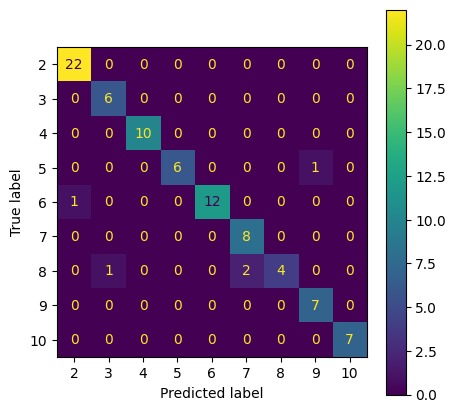

In [ ]:
y_pred = clf2.predict(X_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
print(f"Validation Accuracy: {accuracy}")

print(classification_report(y_test_np, y_pred))
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2, 11))

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

In [ ]:
class_accuracies = {i: [] for i in range(2, 11)}
for j in range(2, 11):
  idx = j - 2
  class_accuracy = cm[idx, idx] / np.sum(cm[idx, :])
  class_accuracies[j].append(class_accuracy)